In [99]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default="iframe"
import seaborn as sns
%matplotlib inline
import string
import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Conv1D, GlobalMaxPooling1D
import keras_tuner as kt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras_tuner as kt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [100]:
data=pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')

# Preprocessing

In [101]:
data['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [102]:
data.drop("Unnamed: 0",axis=1,inplace=True)


## Detection and Removing Missing Values

In [103]:
data.isnull().sum()

statement    362
status         0
dtype: int64

In [104]:
data=data.dropna()

In [105]:
data.isnull().sum()

statement    0
status       0
dtype: int64

In [106]:
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


# EDA

In [107]:
data.describe()

,statement,status
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


In [108]:
status=data['status'].value_counts().unique()
status

array([16343, 15404, 10652,  3841,  2777,  2587,  1077])

In [109]:
labels=['Anxiety','Normal','Depression','Suicidal','Stress','Bipolar','Personality Disorder']
colors=['Gold','mediumturquoise','darkorange','lightgreen','saddlebrown','rebeccapurple']

fig = go.Figure(
    data=[
        go.Pie(
            labels=labels,
            values=status,
            textinfo='label+percent',
            textfont=dict(
                size=15,
                color='black'         
            ),
            marker=dict(colors=colors, pattern=dict(shape=[".", "x", "+", "-",'|','+','x']))
        )
    ]
)

fig.show()

In [110]:
data['num_of_words'] = data['statement'].apply(lambda x: len(str(x).split()))
data['num_of_sentence']=data['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))
data['num_of_characters']=data['statement'].apply(len)
data

,statement,status,num_of_words,num_of_sentence,num_of_characters
0,oh my gosh,Anxiety,3,1,10
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,2,64
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,2,78
3,I've shifted my focus to something else but I'...,Anxiety,11,1,61
4,"I'm restless and restless, it's been a month n...",Anxiety,14,2,72
...,...,...,...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,322,16,1766
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety,198,12,1012
53040,Is there any way to sleep better? I can't slee...,Anxiety,17,2,85
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety,74,6,401


In [111]:
random_stat=data.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])
for status,statement in random_stat.items():
    print(f'Status: {status}')
    print(f'Statement: {statement}')

Status: Anxiety
Statement: finger nails... beaus lines So recently within the past few months i have started to develop horizontal ridges on my finger and toe nails. I googled and discovered they are called beaus lines and they often indicate different diseases. I'm in pretty good health and eat well and exercise often but I'm still concerned as to why i have these horizontal ridges on my nails?? please help if you have any insight
Status: Bipolar
Statement: Realizations In a very bad depression now. And I don't know if it's the depression or what, but I'm am realizing most of my family and friends treat me like shit and really take me for granted. My husband, my kids, hell even my mom. Starting to realize my support system isn't that great. That only makes my depression worse!
Status: Depression
Statement: Every day around my family I am innable to show any emotion. In home it is like "hot and cold" they can yell at me and tell me how useless I am and then because I guess they feel gu

In [112]:
avg_word=data.groupby('status')['num_of_words'].mean().reset_index()
avg_word

,status,num_of_words
0,Anxiety,143.837022
1,Bipolar,176.200216
2,Depression,168.021488
3,Normal,17.246283
4,Personality disorder,179.346332
5,Stress,114.585234
6,Suicidal,146.440293


In [113]:
avg_sent=data.groupby('status')['num_of_sentence'].mean().reset_index()
avg_sent

,status,num_of_sentence
0,Anxiety,8.490758
1,Bipolar,11.046093
2,Depression,7.830369
3,Normal,1.522793
4,Personality disorder,10.675023
5,Stress,6.474681
6,Suicidal,8.794217


In [114]:
avg_char=data.groupby('status')['num_of_characters'].mean().reset_index()
avg_char

,status,num_of_characters
0,Anxiety,764.681073
1,Bipolar,946.074901
2,Depression,844.031161
3,Normal,90.244447
4,Personality disorder,956.731662
5,Stress,613.545419
6,Suicidal,734.967330


In [115]:
col=['num_of_words','num_of_sentence','num_of_characters']

In [116]:
melted_data=data[col].melt(var_name='Variable', value_name='Value')

In [117]:
fig= px.box(melted_data,y='Variable',x='Value', title='Distribution of Num of Statements',color='Variable')
fig.update_layout(xaxis_title='Variables',yaxis_title='Values', showlegend=True)
fig.layout.legend.x=1
fig.layout.legend.y=1
fig.layout.legend.xref='paper'
fig.layout.legend.yref='paper'
fig.layout.legend.font.size=12
fig.layout.legend.title = 'Column Names'
fig.layout.legend.bgcolor='aliceblue'
fig.layout.legend.bordercolor = 'indigo'
fig.layout.legend.borderwidth = 4

fig.show()

In [118]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=avg_word['status'],
    y=avg_word['num_of_words'],
    mode='lines+markers',
    name='Words',
))

fig.add_trace(go.Scatter(
    x=avg_sent['status'],
    y=avg_sent['num_of_sentence'],
    mode='lines+markers',
    name='Sentence',
))

fig.add_trace(go.Scatter(
    x=avg_char['status'],
    y=avg_char['num_of_characters'],
    mode='lines+markers',
    name='Characters',
))
fig.update_layout(
    title='Mean of Number of Words, Sentences, and Characters',
    xaxis_title='Status',
    yaxis_title='Mean Count',
    xaxis=dict(tickmode='linear', tick0=0, dtick=1),
    legend=dict(title='Column Name'),
    hovermode='x'
)

fig.show()

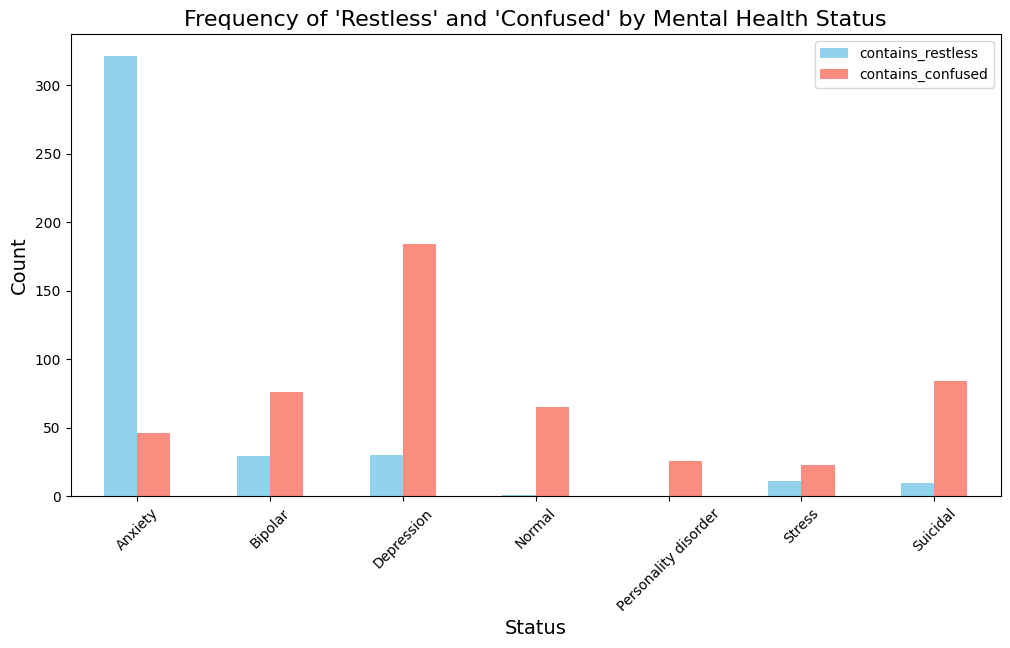

In [119]:
data['contains_restless'] = data['statement'].dropna().apply(lambda x: 'restless' in x.lower())
data['contains_confused'] = data['statement'].dropna().apply(lambda x: 'confused' in x.lower())

word_counts = data.groupby('status')[['contains_restless', 'contains_confused']].sum()
word_counts.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'salmon'], alpha=0.9)
plt.title("Frequency of 'Restless' and 'Confused' by Mental Health Status", fontsize=16)
plt.xlabel("Status", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.show()

## Lower Casing

In [120]:
data['statement']=data['statement'].str.lower()
data

,statement,status,num_of_words,num_of_sentence,num_of_characters,contains_restless,contains_confused
0,oh my gosh,Anxiety,3,1,10,False,False
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,2,64,True,True
2,"all wrong, back off dear, forward doubt. stay ...",Anxiety,14,2,78,True,False
3,i've shifted my focus to something else but i'...,Anxiety,11,1,61,False,False
4,"i'm restless and restless, it's been a month n...",Anxiety,14,2,72,True,False
...,...,...,...,...,...,...,...
53038,nobody takes me seriously i’ve (24m) dealt wit...,Anxiety,322,16,1766,False,False
53039,"selfishness ""i don't feel very good, it's lik...",Anxiety,198,12,1012,False,False
53040,is there any way to sleep better? i can't slee...,Anxiety,17,2,85,False,False
53041,"public speaking tips? hi, all. i have to give ...",Anxiety,74,6,401,False,False


### ***Removing Punctuation, Unicode Characters, Unwanted Patterns and URL***

In [121]:
def removing(text):
    #for removing URLs
    text=re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    #removing markdown-style links
    text=re.sub(r'\[.*?\]\(.*?\)','',text)
    #removing square brackets
    text = re.sub(r'\[.*?\]', '', text)
    #remove HTML tags
    text = re.sub(r'<.*?>+', '', text)
    #remove@
    text=re.sub(r'@\w+','',text)
    #remove punctuation and special characters
    text=re.sub(r'[^\w\s]','',text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    #removing age and gender patterns like 24M or 30F
    text=re.sub(r'\b\d{1,3}[mf]\b','',text)
    text=re.sub(r'\b\d{1,3}[MF]\b','',text)

    pattern = r'\b(?:ive|im|hes|shes|theyre|weve|youve|cant|wont|isnt|arent|wasnt|hi|werent|havent|hasnt|didnt|doesnt|youre|id|hed|dont|else|shed|theyd|itd|wed|youd)\b'

    # Remove the matching contractions (case-insensitive)
    text = re.sub(pattern, '', text, flags=re.IGNORECASE)


    #removing new lines
    text = re.sub(r'\n', '', text) 
    return text.strip()

data['statement']=data['statement'].apply(removing)
data.statement

0                                               oh my gosh
1        trouble sleeping confused mind restless heart ...
2        all wrong back off dear forward doubt stay in ...
3        shifted my focus to something  but  still worried
4        restless and restless its been a month now boy...
                               ...                        
53038    nobody takes me seriously   dealt with depress...
53039    selfishness  i  feel very good its like i  bel...
53040    is there any way to sleep better i  sleep most...
53041    public speaking tips  all i have to give a pre...
53042    i have really bad door anxiety its not about b...
Name: statement, Length: 52681, dtype: object

In [122]:
stop_words=set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['cleaned_statement'] = data['statement'].apply(lambda x: remove_stopwords(x))
data

,statement,status,num_of_words,num_of_sentence,num_of_characters,contains_restless,contains_confused,cleaned_statement
0,oh my gosh,Anxiety,3,1,10,False,False,oh gosh
1,trouble sleeping confused mind restless heart ...,Anxiety,10,2,64,True,True,trouble sleeping confused mind restless heart ...
2,all wrong back off dear forward doubt stay in ...,Anxiety,14,2,78,True,False,wrong back dear forward doubt stay restless re...
3,shifted my focus to something but still worried,Anxiety,11,1,61,False,False,shifted focus something still worried
4,restless and restless its been a month now boy...,Anxiety,14,2,72,True,False,restless restless month boy mean
...,...,...,...,...,...,...,...,...
53038,nobody takes me seriously dealt with depress...,Anxiety,322,16,1766,False,False,nobody takes seriously dealt depressionanxiety...
53039,selfishness i feel very good its like i bel...,Anxiety,198,12,1012,False,False,selfishness feel good like belong world think ...
53040,is there any way to sleep better i sleep most...,Anxiety,17,2,85,False,False,way sleep better sleep nights meds help
53041,public speaking tips all i have to give a pre...,Anxiety,74,6,401,False,False,public speaking tips give presentation work ne...


In [123]:
data['tokens']=data['cleaned_statement'].apply(word_tokenize)
data

,statement,status,num_of_words,num_of_sentence,num_of_characters,contains_restless,contains_confused,cleaned_statement,tokens
0,oh my gosh,Anxiety,3,1,10,False,False,oh gosh,"[oh, gosh]"
1,trouble sleeping confused mind restless heart ...,Anxiety,10,2,64,True,True,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,all wrong back off dear forward doubt stay in ...,Anxiety,14,2,78,True,False,wrong back dear forward doubt stay restless re...,"[wrong, back, dear, forward, doubt, stay, rest..."
3,shifted my focus to something but still worried,Anxiety,11,1,61,False,False,shifted focus something still worried,"[shifted, focus, something, still, worried]"
4,restless and restless its been a month now boy...,Anxiety,14,2,72,True,False,restless restless month boy mean,"[restless, restless, month, boy, mean]"
...,...,...,...,...,...,...,...,...,...
53038,nobody takes me seriously dealt with depress...,Anxiety,322,16,1766,False,False,nobody takes seriously dealt depressionanxiety...,"[nobody, takes, seriously, dealt, depressionan..."
53039,selfishness i feel very good its like i bel...,Anxiety,198,12,1012,False,False,selfishness feel good like belong world think ...,"[selfishness, feel, good, like, belong, world,..."
53040,is there any way to sleep better i sleep most...,Anxiety,17,2,85,False,False,way sleep better sleep nights meds help,"[way, sleep, better, sleep, nights, meds, help]"
53041,public speaking tips all i have to give a pre...,Anxiety,74,6,401,False,False,public speaking tips give presentation work ne...,"[public, speaking, tips, give, presentation, w..."


# ***POS Analysis***

In [124]:
def pos_analysis(tokens):
   
    pos_mapping = {
        'JJ': 'Adjective', 'JJR': 'Adjective', 'JJS': 'Adjective',
        'NN': 'Noun', 'NNS': 'Noun', 'NNP': 'Noun', 'NNPS': 'Noun',
        'VB': 'Verb', 'VBD': 'Verb', 'VBG': 'Verb', 'VBN': 'Verb', 'VBP': 'Verb', 'VBZ': 'Verb',
        'RB': 'Adverb', 'RBR': 'Adverb', 'RBS': 'Adverb',
    }

    tagged = pos_tag(tokens)

    pos_count = defaultdict(int)
    pos_words = defaultdict(list)

    for word, tag in tagged:

        if tag in pos_mapping:
            category = pos_mapping[tag]
            pos_count[category] += 1
            pos_words[category].append(word)

    return {
        'pos_count': pos_count,
        'pos_words': pos_words,
    }

In [125]:
def analyze_row(row):
    result = pos_analysis(row)

    return pd.Series({
        'Adjectives': ', '.join(result['pos_words'].get('Adjective', [])),
        'Adjective_Count': result['pos_count'].get('Adjective', 0),
        'Nouns': ', '.join(result['pos_words'].get('Noun', [])),
        'Noun_Count': result['pos_count'].get('Noun', 0),
        'Verbs': ', '.join(result['pos_words'].get('Verb', [])),
        'Verb_Count': result['pos_count'].get('Verb', 0),
        'Adverbs': ', '.join(result['pos_words'].get('Adverb', [])),
        'Adverb_Count': result['pos_count'].get('Adverb', 0),
    })

pos_results = data['tokens'].apply(analyze_row)

data = pd.concat([data, pos_results], axis=1)

In [126]:
pd.set_option('display.max_columns', None)
data.head()

,statement,status,num_of_words,num_of_sentence,num_of_characters,contains_restless,contains_confused,cleaned_statement,tokens,Adjectives,Adjective_Count,Nouns,Noun_Count,Verbs,Verb_Count,Adverbs,Adverb_Count
0,oh my gosh,Anxiety,3,1,10,False,False,oh gosh,"[oh, gosh]",,0,gosh,1,,0,,0
1,trouble sleeping confused mind restless heart ...,Anxiety,10,2,64,True,True,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",restless,1,"trouble, mind, heart, tune",4,"sleeping, confused",2,,0
2,all wrong back off dear forward doubt stay in ...,Anxiety,14,2,78,True,False,wrong back dear forward doubt stay restless re...,"[wrong, back, dear, forward, doubt, stay, rest...","wrong, dear, restless",3,"forward, doubt, restless, place",4,stay,1,back,1
3,shifted my focus to something but still worried,Anxiety,11,1,61,False,False,shifted focus something still worried,"[shifted, focus, something, still, worried]",,0,"focus, something",2,"shifted, worried",2,still,1
4,restless and restless its been a month now boy...,Anxiety,14,2,72,True,False,restless restless month boy mean,"[restless, restless, month, boy, mean]","restless, restless",2,"month, mean",2,boy,1,,0


In [127]:
numeric_cols = data.select_dtypes(include=['int', 'float']).columns
for col in numeric_cols:
    print(col, (data[col] == 0).sum())

num_of_words 0
num_of_sentence 0
num_of_characters 0
Adjective_Count 7900
Noun_Count 1053
Verb_Count 6146
Adverb_Count 14463


In [128]:
pos_cols = [
    'Adjective_Count',
    'Noun_Count',
    'Verb_Count',
    'Adverb_Count'
]

In [129]:
data_avg = data.groupby('status')[pos_cols + ['num_of_words']].mean().reset_index()

In [130]:
for col in pos_cols:
    ratio_col = col + '_ratio'
    data_avg[ratio_col] = data_avg[col] / data_avg['num_of_words']

In [131]:
data_avg

,status,Adjective_Count,Noun_Count,Verb_Count,Adverb_Count,num_of_words,Adjective_Count_ratio,Noun_Count_ratio,Verb_Count_ratio,Adverb_Count_ratio
0,Anxiety,12.360844,27.221297,16.610518,6.813330,143.837022,0.085936,0.189251,0.115482,0.047368
1,Bipolar,15.395031,31.979834,20.339215,8.074181,176.200216,0.087372,0.181497,0.115432,0.045824
2,Depression,13.160997,28.320696,18.935666,7.857310,168.021488,0.078329,0.168554,0.112698,0.046764
3,Normal,1.441106,4.111913,1.871015,0.700973,17.246283,0.083560,0.238423,0.108488,0.040645
4,Personality disorder,14.773445,30.737233,20.568245,8.984215,179.346332,0.082374,0.171385,0.114685,0.050094
5,Stress,9.185543,21.439505,13.271357,5.020487,114.585234,0.080163,0.187105,0.115821,0.043814
6,Suicidal,11.149268,23.557360,16.938415,6.752816,146.440293,0.076135,0.160867,0.115668,0.046113


In [132]:
pos_ratio_cols = [col + '_ratio' for col in pos_cols]

melted_counts = data_avg.melt(
    id_vars='status',
    value_vars=pos_cols,
    var_name='pos_type',
    value_name='average_count'
)

melted_ratios = data_avg.melt(
    id_vars='status',
    value_vars=pos_ratio_cols,
    var_name='pos_type',
    value_name='ratio'
)

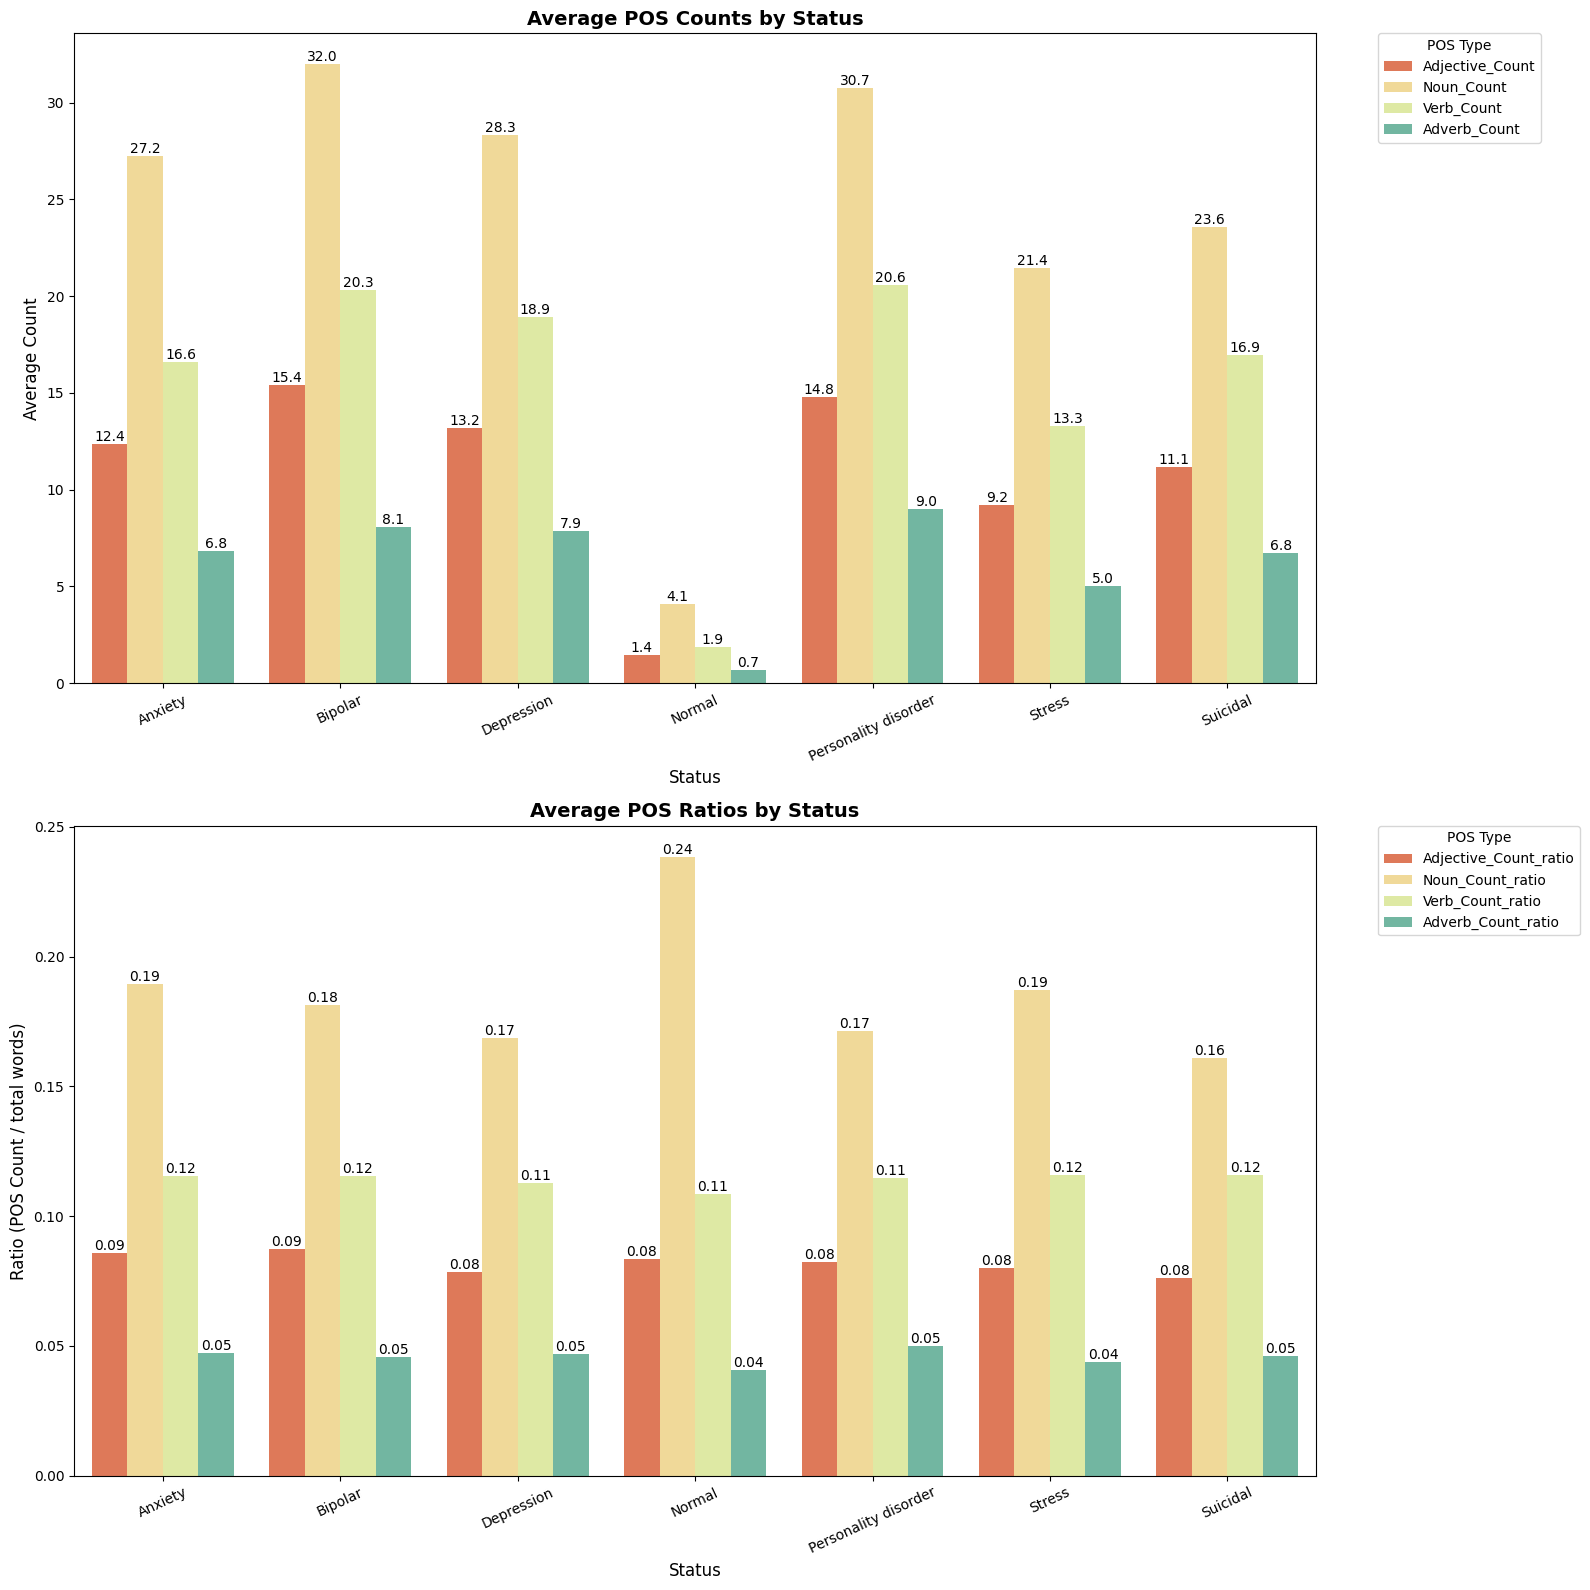

In [133]:
fig, axes = plt.subplots(2, 1, figsize=(16, 16))

palette = sns.color_palette("Spectral", n_colors=len(pos_cols))

sns.barplot(
    data=melted_counts,
    x='status',
    y='average_count',
    hue='pos_type',
    ax=axes[0],
    palette=palette
)
axes[0].set_title('Average POS Counts by Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Status', fontsize=12)
axes[0].set_ylabel('Average Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=25)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.1f", label_type="edge", fontsize=10)

axes[0].legend(title='POS Type', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

sns.barplot(
    data=melted_ratios,
    x='status',
    y='ratio',
    hue='pos_type',
    ax=axes[1],
    palette=palette
)
axes[1].set_title('Average POS Ratios by Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Status', fontsize=12)
axes[1].set_ylabel('Ratio (POS Count / total words)', fontsize=12)
axes[1].tick_params(axis='x', rotation=25)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f", label_type="edge", fontsize=10)

axes[1].legend(title='POS Type', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

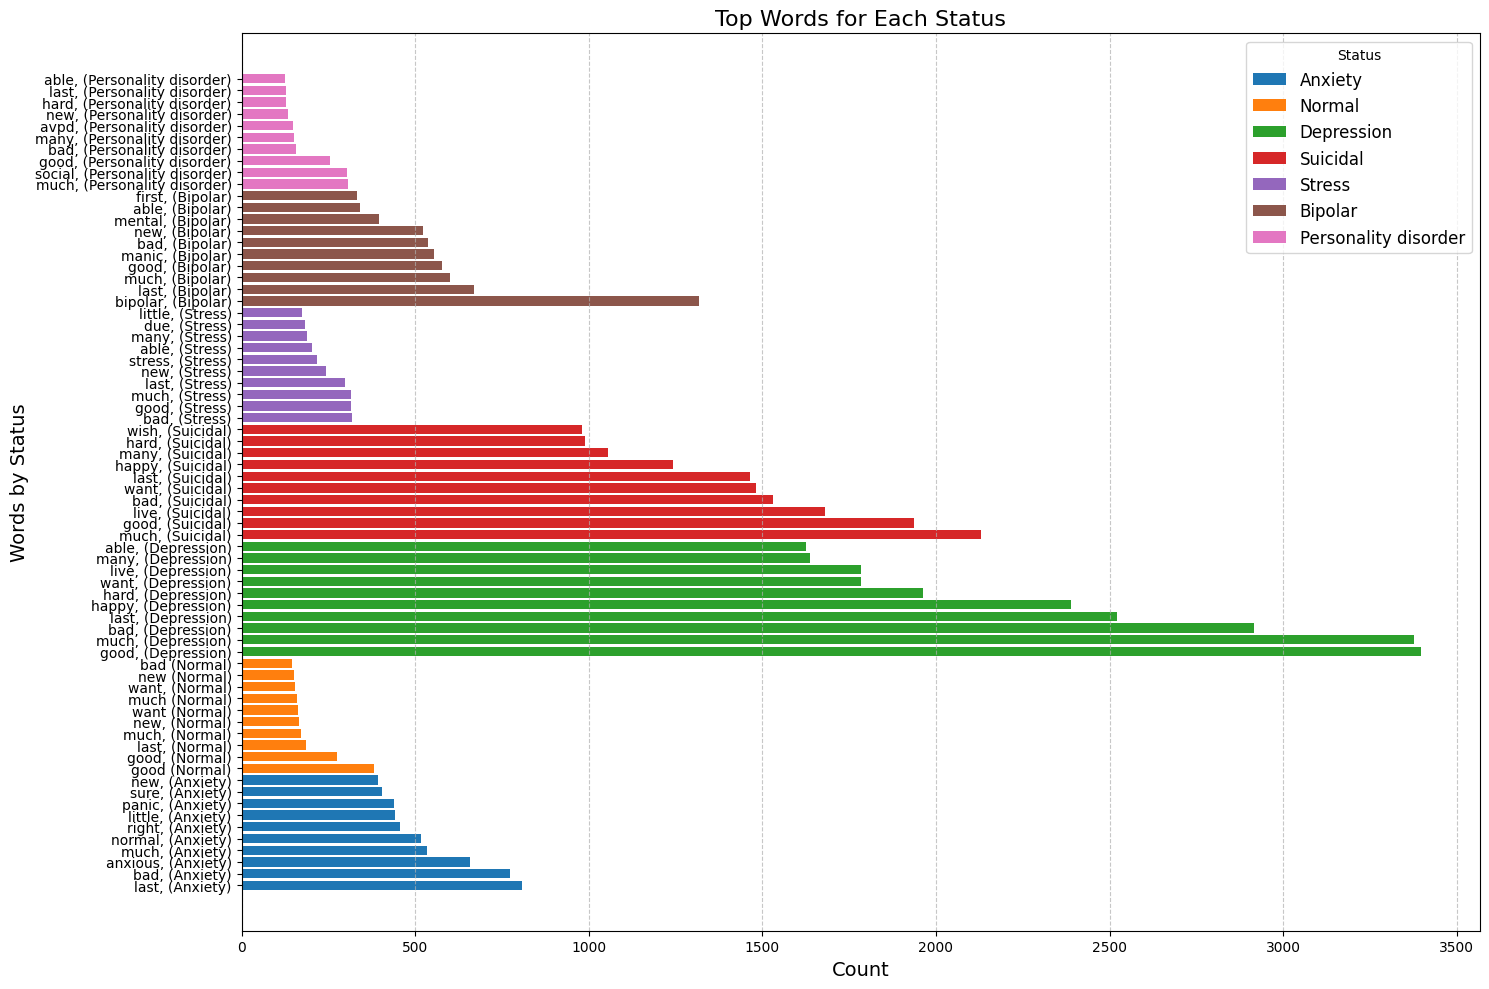

In [134]:
plot_data = []


statuses = data['status'].dropna().unique()


for status in statuses:
    words = ' '.join(data[data['status'] == status]['Adjectives'].dropna()).split()
    word_counts = Counter(words).most_common(10)
    for word, count in word_counts:
        plot_data.append({'status': status, 'word': word, 'count': count})


word_df = pd.DataFrame(plot_data)


plt.figure(figsize=(15, 10))
statuses = word_df['status'].unique()

for i, status in enumerate(statuses):
    subset = word_df[word_df['status'] == status]
    plt.barh(subset['word'] + f" ({status})", subset['count'], label=status)

plt.title("Top Words for Each Status", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Words by Status", fontsize=14)
plt.legend(title="Status", loc='upper right', fontsize=12)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import math

num_cols = 2
num_rows = math.ceil(len(statuses) / num_cols)
plt.figure(figsize=(14, 4 * num_rows))

for i, status in enumerate(statuses):

    df_sub = data.loc[data['status'] == status, 'cleaned_statement'].dropna()

    text_all = " ".join(df_sub.tolist())

    vectorizer = CountVectorizer(ngram_range=(2,2), max_features=50)
    X = vectorizer.fit_transform([text_all]) 
    bigram_freqs = X.toarray()[0]
    bigram_features = vectorizer.get_feature_names_out()

    freq_dict = dict(zip(bigram_features, bigram_freqs))

    if sum(freq_dict.values()) == 0:
        print(f"No bigrams found for status '{status}'. Skipping.")
        continue

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='plasma'
    ).generate_from_frequencies(freq_dict)

    ax = plt.subplot(num_rows, num_cols, i + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Bigrams WordCloud: {status}", fontsize=14, pad=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [136]:
data

,statement,status,num_of_words,num_of_sentence,num_of_characters,contains_restless,contains_confused,cleaned_statement,tokens,Adjectives,Adjective_Count,Nouns,Noun_Count,Verbs,Verb_Count,Adverbs,Adverb_Count
0,oh my gosh,Anxiety,3,1,10,False,False,oh gosh,"[oh, gosh]",,0,gosh,1,,0,,0
1,trouble sleeping confused mind restless heart ...,Anxiety,10,2,64,True,True,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",restless,1,"trouble, mind, heart, tune",4,"sleeping, confused",2,,0
2,all wrong back off dear forward doubt stay in ...,Anxiety,14,2,78,True,False,wrong back dear forward doubt stay restless re...,"[wrong, back, dear, forward, doubt, stay, rest...","wrong, dear, restless",3,"forward, doubt, restless, place",4,stay,1,back,1
3,shifted my focus to something but still worried,Anxiety,11,1,61,False,False,shifted focus something still worried,"[shifted, focus, something, still, worried]",,0,"focus, something",2,"shifted, worried",2,still,1
4,restless and restless its been a month now boy...,Anxiety,14,2,72,True,False,restless restless month boy mean,"[restless, restless, month, boy, mean]","restless, restless",2,"month, mean",2,boy,1,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53038,nobody takes me seriously dealt with depress...,Anxiety,322,16,1766,False,False,nobody takes seriously dealt depressionanxiety...,"[nobody, takes, seriously, dealt, depressionan...","dealt, great, good, nice, great, girlfriend, s...",30,"nobody, depressionanxiety, years, people, mone...",56,"takes, used, make, say, looked, diagnosed, los...",44,"seriously, even, yet, eventually, even, back, ...",20
53039,selfishness i feel very good its like i bel...,Anxiety,198,12,1012,False,False,selfishness feel good like belong world think ...,"[selfishness, feel, good, like, belong, world,...","good, belong, happy, funny, little, possible, ...",19,"selfishness, world, friends, whos, ruins, try,...",29,"feel, think, mood, say, ask, say, think, find,...",24,"ever, always, really, always, ago, brother, pr...",9
53040,is there any way to sleep better i sleep most...,Anxiety,17,2,85,False,False,way sleep better sleep nights meds help,"[way, sleep, better, sleep, nights, meds, help]","better, sleep",2,"way, nights, meds",3,"sleep, help",2,,0
53041,public speaking tips all i have to give a pre...,Anxiety,74,6,401,False,False,public speaking tips give presentation work ne...,"[public, speaking, tips, give, presentation, w...","public, give, next, ceo, certain, say, difficu...",8,"tips, presentation, work, week, minutes, atten...",15,"speaking, panicking, going, supposed, makes, f...",8,"long, already, much",3


In [137]:
le = LabelEncoder()
data['status_label'] = le.fit_transform(data['status'])

In [138]:
data.status_label.unique()

array([0, 3, 2, 6, 5, 1, 4])

In [139]:
data.status.unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

***After Label Encoding to Status***

- Anxiety -> 0
- Bipolar -> 1
- Depression -> 2 
- Normal -> 3
- Personal Disorder -> 4
- Stress -> 5 
- Suicidal -> 6

In [140]:
data.columns

Index(['statement', 'status', 'num_of_words', 'num_of_sentence',
       'num_of_characters', 'contains_restless', 'contains_confused',
       'cleaned_statement', 'tokens', 'Adjectives', 'Adjective_Count', 'Nouns',
       'Noun_Count', 'Verbs', 'Verb_Count', 'Adverbs', 'Adverb_Count',
       'status_label'],
      dtype='object')

We need to make label encoding Adjectives, Nouns, Verbs, Adverbs  colums to find which of them used for detecting to status.


In [141]:
data['Adj_le'] = le.fit_transform(data['Adjectives'])
data['N_le'] = le.fit_transform(data['Nouns'])
data['V_le'] = le.fit_transform(data['Verbs'])
data['Adv_le'] = le.fit_transform(data['Adverbs'])


In [142]:
data_copy=data[[ 'status', 'num_of_words', 'num_of_sentence',
       'num_of_characters',
       'cleaned_statement', 'Adjective_Count',
       'Noun_Count', 'Verb_Count', 'Adverb_Count', 'Adj_le', 'N_le', 'V_le', 'Adv_le']]

In [143]:
data_copy

,status,num_of_words,num_of_sentence,num_of_characters,cleaned_statement,Adjective_Count,Noun_Count,Verb_Count,Adverb_Count,Adj_le,N_le,V_le,Adv_le
0,Anxiety,3,1,10,oh gosh,0,1,0,0,0,16397,0,0
1,Anxiety,10,2,64,trouble sleeping confused mind restless heart ...,1,4,2,0,27267,43002,29452,0
2,Anxiety,14,2,78,wrong back dear forward doubt stay restless re...,3,4,1,1,37938,14781,30666,5777
3,Anxiety,11,1,61,shifted focus something still worried,0,2,2,1,0,14634,29029,25748
4,Anxiety,14,2,72,restless restless month boy mean,2,2,1,0,27286,26917,2239,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53038,Anxiety,322,16,1766,nobody takes seriously dealt depressionanxiety...,30,56,44,20,6421,28648,32715,24327
53039,Anxiety,198,12,1012,selfishness feel good like belong world think ...,19,29,24,9,11691,35387,9128,10988
53040,Anxiety,17,2,85,way sleep better sleep nights meds help,2,3,2,0,3328,44760,29420,0
53041,Anxiety,74,6,401,public speaking tips give presentation work ne...,8,15,8,3,26248,42018,29809,16128


In [144]:
feature_cols = [
    'Adjective_Count','Noun_Count','Verb_Count', 'Adverb_Count',
    'num_of_words', 'num_of_sentence', 'num_of_characters'
]

X_fe = data[feature_cols]
y_fe = data['status_label']

In [145]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_fe, y_fe)

importances = rf.feature_importances_

data_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

data_importances

,feature,importance
6,num_of_characters,0.264471
4,num_of_words,0.203271
1,Noun_Count,0.123722
2,Verb_Count,0.121228
0,Adjective_Count,0.101448
5,num_of_sentence,0.100645
3,Adverb_Count,0.085215


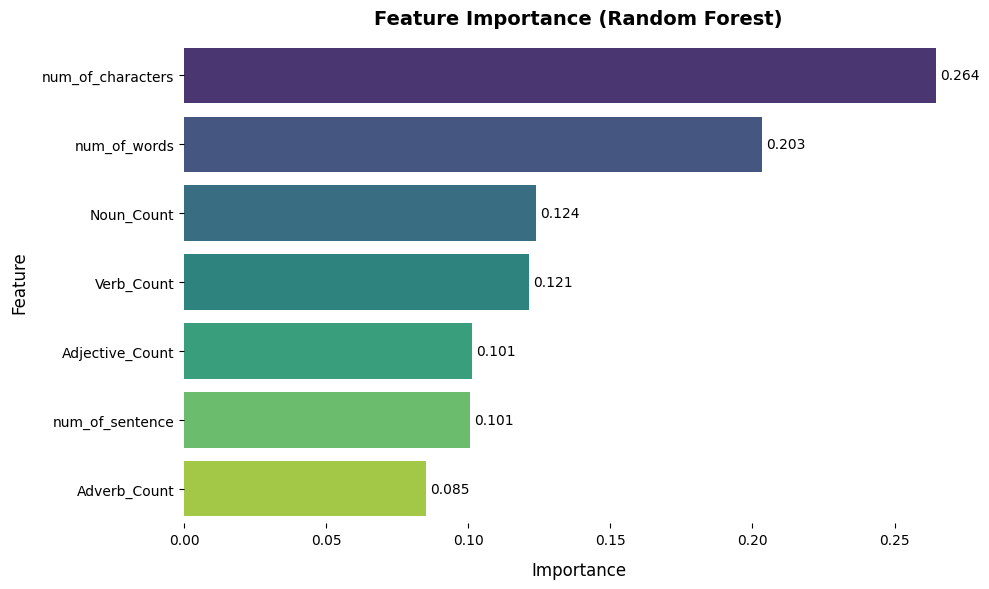

In [146]:
plt.figure(figsize=(10, 6))

g = sns.barplot(
    data=data_importances, 
    x='importance', 
    y='feature', 
    palette='viridis'
)

plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold', pad=12)
plt.xlabel('Importance', fontsize=12, labelpad=10)
plt.ylabel('Feature', fontsize=12, labelpad=10)

for container in g.containers:
    g.bar_label(container, fmt='%.3f', label_type='edge', padding=3)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

## Feature Selection & Spilitting Data as Test and Train

In [147]:
df=data[['status','cleaned_statement','num_of_characters','num_of_words']]

In [148]:
df.isnull().sum()

status               0
cleaned_statement    0
num_of_characters    0
num_of_words         0
dtype: int64

In [149]:
df

,status,cleaned_statement,num_of_characters,num_of_words
0,Anxiety,oh gosh,10,3
1,Anxiety,trouble sleeping confused mind restless heart ...,64,10
2,Anxiety,wrong back dear forward doubt stay restless re...,78,14
3,Anxiety,shifted focus something still worried,61,11
4,Anxiety,restless restless month boy mean,72,14
...,...,...,...,...
53038,Anxiety,nobody takes seriously dealt depressionanxiety...,1766,322
53039,Anxiety,selfishness feel good like belong world think ...,1012,198
53040,Anxiety,way sleep better sleep nights meds help,85,17
53041,Anxiety,public speaking tips give presentation work ne...,401,74


In [150]:
X_text=df['cleaned_statement']

y=df['status']

In [151]:
tfidf = TfidfVectorizer(max_features=5000)
X_text_tfidf = tfidf.fit_transform(X_text)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_text_tfidf, y, test_size=0.2, random_state=42, stratify=y)


## Model Selection

Logistic Regression
Naive Bayes
SVM
Random Forest
XGBoost
LightGBM
CatBoost
LSTM
BERT
GPT
CNN + Global Pooling
Pretrained Embedding + CNN

Perform hyperparameter tuning with tools like KerasTuner or GridSearchCV.


#### Logistic Regression

In [153]:
le = LabelEncoder()

In [154]:
y_train_le=le.fit_transform(y_train)
y_test_le=le.fit_transform(y_test)

In [155]:
y_train_le

array([2, 3, 2, ..., 1, 2, 3])

In [156]:
lr=LogisticRegression(random_state=42, max_iter=5000)
lr_params={'penalty': ['l1', 'l2','elasticnet'],'C':[0.01, 0.1, 1, 10, 100]}
lr_grid=GridSearchCV(lr,lr_params,cv=3,scoring='accuracy')
lr_grid.fit(X_train,y_train_le)
print("Best Logistic Regression Params:", lr_grid.best_params_)

Best Logistic Regression Params: {'C': 1, 'penalty': 'l2'}


In [157]:
best_lr_model=lr_grid.best_estimator_


In [158]:
best_lr_model

LogisticRegression(C=1, max_iter=5000, random_state=42)

In [159]:
y_pred_lr=best_lr_model.predict(X_test)

In [160]:
accuracy_lr=accuracy_score(y_test_le,y_pred_lr)

In [161]:
print(f"Accuracy of the best Logistic Regression model: {accuracy_lr * 100:.2f}%")


Accuracy of the best Logistic Regression model: 74.83%


In [162]:
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_le, y_pred_lr))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       768
           1       0.89      0.62      0.73       556
           2       0.68      0.74      0.71      3081
           3       0.83      0.95      0.88      3269
           4       0.89      0.40      0.55       215
           5       0.68      0.37      0.47       517
           6       0.67      0.62      0.64      2131

    accuracy                           0.75     10537
   macro avg       0.78      0.63      0.68     10537
weighted avg       0.75      0.75      0.74     10537



#### FNN

X_text=df['cleaned_statement']


y=df['status']


X_train, X_test, y_train, y_test

y_train_le=le.fit_transform(y_train)
y_test_le=le.fit_transform(y_test)

In [163]:
from tensorflow.keras.optimizers import Adam

nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])
 
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the optimizer
nn_model.compile(optimizer=optimizer, 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])
 
nn_history = nn_model.fit(
    X_train.toarray(),  
    y_train_le,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)
 
 
test_loss, test_accuracy = nn_model.evaluate(X_test.toarray(), y_test_le, verbose=0)
 
 
print(f"Test Accuracy: {test_accuracy:.4f}")
 
 
from sklearn.metrics import classification_report
y_pred_fnn = nn_model.predict(X_test.toarray(), verbose=0).argmax(axis=1)
print(classification_report(y_test_le, y_pred_fnn, target_names=le.classes_))

Epoch 1/10
527/527 [==============================] - 5s 9ms/step - loss: 1.1614 - accuracy: 0.5753 - val_loss: 0.7784 - val_accuracy: 0.7192
Epoch 2/10
527/527 [==============================] - 4s 8ms/step - loss: 0.7122 - accuracy: 0.7435 - val_loss: 0.6849 - val_accuracy: 0.7494
Epoch 3/10
527/527 [==============================] - 4s 7ms/step - loss: 0.5791 - accuracy: 0.7941 - val_loss: 0.6642 - val_accuracy: 0.7561
Epoch 4/10
527/527 [==============================] - 4s 8ms/step - loss: 0.4980 - accuracy: 0.8223 - val_loss: 0.6694 - val_accuracy: 0.7580
Epoch 5/10
527/527 [==============================] - 4s 8ms/step - loss: 0.4299 - accuracy: 0.8475 - val_loss: 0.6952 - val_accuracy: 0.7529
Epoch 6/10
527/527 [==============================] - 4s 8ms/step - loss: 0.3773 - accuracy: 0.8682 - val_loss: 0.7228 - val_accuracy: 0.7498
Epoch 7/10
527/527 [==============================] - 4s 8ms/step - loss: 0.3292 - accuracy: 0.8852 - val_loss: 0.7522 - val_accuracy: 0.7480
Epoch 

#### MLP

)

In [164]:
from sklearn.neural_network import MLPClassifier
 
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train_le)
 
y_pred_mlp = mlp_model.predict(X_test)
print("Neural Network Results:")
print(classification_report( y_test_le, y_pred_mlp))
print("Accuracy:", accuracy_score( y_test_le, y_pred_mlp))

Neural Network Results:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       768
           1       0.76      0.72      0.74       556
           2       0.65      0.72      0.68      3081
           3       0.87      0.91      0.89      3269
           4       0.64      0.62      0.63       215
           5       0.57      0.49      0.52       517
           6       0.64      0.55      0.59      2131

    accuracy                           0.73     10537
   macro avg       0.70      0.68      0.69     10537
weighted avg       0.73      0.73      0.73     10537

Accuracy: 0.7310429913637658


#### LSTM


In [97]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
 
max_words=5000
max_sequence_length=50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text)
X_text_sequences = tokenizer.texts_to_sequences(X_text)
X_text_padded = pad_sequences(X_text_sequences, maxlen=max_sequence_length,padding='post')

X_train_text, X_test_text,  y_train_lstm, y_test_lstm = train_test_split(
    X_text_padded, y, test_size=0.2, random_state=42, stratify=y
)
y_train_le_lstm=le.fit_transform(y_train_lstm)
y_test_le_lstm=le.fit_transform(y_test_lstm)
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])
 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_text, y_train_le_lstm, validation_data=(X_test_text, y_test_le_lstm), epochs=5, batch_size=32)
 
y_pred_lstm = model.predict(X_test_text)
y_pred_lstm_classes = y_pred_lstm.argmax(axis=1)
print("LSTM Results:")
print(classification_report(y_test_le_lstm, y_pred_lstm_classes))

Epoch 1/5
1317/1317 [==============================] - 96s 71ms/step - loss: 1.1606 - accuracy: 0.5583 - val_loss: 0.9571 - val_accuracy: 0.6082
Epoch 2/5
1317/1317 [==============================] - 94s 71ms/step - loss: 0.9162 - accuracy: 0.6569 - val_loss: 0.8823 - val_accuracy: 0.6750
Epoch 3/5
1317/1317 [==============================] - 101s 76ms/step - loss: 0.7880 - accuracy: 0.7186 - val_loss: 0.8032 - val_accuracy: 0.7170
Epoch 4/5
1317/1317 [==============================] - 95s 72ms/step - loss: 0.6856 - accuracy: 0.7594 - val_loss: 0.7677 - val_accuracy: 0.7253
Epoch 5/5
330/330 [==============================] - 9s 25ms/step
LSTM Results:
              precision    recall  f1-score   support

           0       0.65      0.80      0.72       768
           1       0.77      0.69      0.73       556
           2       0.70      0.61      0.66      3081
           3       0.90      0.90      0.90      3269
           4       0.75      0.33      0.45       215
           5  

####  BERT + XGBoost

Machine Learning Pipeline

The pipeline consists of:

1.	Sampling & Balancing the Data (to avoid class imbalance issues)
2.	Embedding Text using BERT (to convert text into meaningful numerical representations)
3.	Training an XGBoost Classifier (a powerful gradient boosting algorithm)


####

In [70]:
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.utils import resample
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.utils import resample
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import warnings
warnings.filterwarnings('ignore')

In [71]:
df.shape

(52681, 4)

In [72]:
label_ordered = df['status'].value_counts().index

label_ordered = {k:i for i,k in enumerate(label_ordered,0)}

label_ordered

{'Normal': 0,
 'Depression': 1,
 'Suicidal': 2,
 'Anxiety': 3,
 'Bipolar': 4,
 'Stress': 5,
 'Personality disorder': 6}

In [73]:
df['status'] = df['status'].map(label_ordered)
df.head()

,status,cleaned_statement,num_of_characters,num_of_words
0,3,oh gosh,10,3
1,3,trouble sleeping confused mind restless heart ...,64,10
2,3,wrong back dear forward doubt stay restless re...,78,14
3,3,shifted focus something still worried,61,11
4,3,restless restless month boy mean,72,14


In [74]:
print(df['status'].value_counts())


status
0    16343
1    15404
2    10652
3     3841
4     2777
5     2587
6     1077
Name: count, dtype: int64


If we train a model on this dataset:
- The model might always predict the majority class (0: Legitimate) because it appears more frequently.
- Accuracy might be high, but the model fails to detect fraudulent cases (1).
- This leads to a biased and unreliable model


Step	Process	Purpose
1️⃣ Identify Class Distribution	
- Count the number of samples in each class	
- Detect imbalance
  
2️⃣ Resample Data
- Apply oversampling or undersampling
- Balance the dataset
  
3️⃣ Train Model	
- Use the balanced dataset for training
- Improve accuracy & fairness


In [75]:
df_sample = df.sample(n=20000,random_state=2024)
majority_size = len(df_sample[df_sample['status']==0])

majority_size

6140

In [76]:

from sklearn.utils import resample

def resampling_dfs(df):
    resample_minority = resample(df, replace=True, n_samples=majority_size, random_state= 768)
    return resample_minority


In [77]:
df_sample

,status,cleaned_statement,num_of_characters,num_of_words
43491,0,caitlinaudrey awww suck going sydney one,60,11
46017,4,feel like killing still one listens convinced ...,1355,259
24191,2,dl hellome hellodl hello know saydl okay dl so...,642,101
6893,0,body ache,9,2
40455,1,feel like believe really going trial run see g...,150,37
...,...,...,...,...
45045,0,argh stop yawning,22,4
17141,2,people love say suicide selfish way around sel...,229,44
42853,0,riskyrevenge wait sick,27,4
40028,1,long story sorry ex broke year ago remained fr...,7747,1726


In [78]:
df_sample_0 = resampling_dfs(df_sample[df_sample['status']==0])
df_sample_1 = resampling_dfs(df_sample[df_sample['status']==1])
df_sample_2 = resampling_dfs(df_sample[df_sample['status']==2])
df_sample_3 = resampling_dfs(df_sample[df_sample['status']==3])
df_sample_4 = resampling_dfs(df_sample[df_sample['status']==4])
df_sample_5 = resampling_dfs(df_sample[df_sample['status']==5])
df_sample_6 = resampling_dfs(df_sample[df_sample['status']==6])

df_new =pd.concat([df_sample_0,df_sample_1,df_sample_2,df_sample_3,df_sample_4,df_sample_5,df_sample_6], axis=0).reset_index(drop=True)

df_new['status'].value_counts()

status
0    6140
1    6140
2    6140
3    6140
4    6140
5    6140
6    6140
Name: count, dtype: int64

In [79]:
df_new

,status,cleaned_statement,num_of_characters,num_of_words
0,0,secret achieving success success happen prepar...,127,21
1,0,proud,10,2
2,0,seen far couple lizards,45,10
3,0,tell,31,6
4,0,welcome twitter,28,4
...,...,...,...,...
42975,6,interview anxiety job searching since august o...,508,91
42976,6,trying make friend someone lot friends making ...,1216,238
42977,6,please hear success stories yall got share,70,13
42978,6,also want get rid avpd avoiding makes much sen...,398,73


In [81]:
print("TF version:", tf.__version__)    # Should be 2.9, 2.10, 2.11, etc.
print("Hub version:", hub.__version__)  # ~0.12 or newer
print("Text version:", text.__version__)

TF version: 2.9.0
Hub version: 0.16.1
Text version: 2.9.0


Why Use BERT for Text Embeddings?
- Machine learning models can't understand text directly. They need numerical representations.
- Traditional techniques (like TF-IDF or Word2Vec) have limitations in understanding context.
- BERT (Bidirectional Encoder Representations from Transformers) is a deep learning model developed by Google that:
  - Understands contextual meaning by looking at words in both directions (left and right).
  - Is pre-trained on massive text corpora (Wikipedia, books, etc.), so it understands language better than older models.


#### What is Happening Here?

1.	***bert_preprocess:***
    - Handles tokenization, lowercasing, and adding special tokens (like [CLS] for classification tasks).
    - Converts text into a format BERT understands.
2.	***bert_encoder:***
    - Uses the BERT model to generate embeddings.
    - Outputs 768-dimensional feature vectors for each input sentence.


In [82]:
bert_preprocess = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    name="bert_preprocess_layer"
)
bert_encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True,
    name="bert_encoder_layer"
)


- Takes raw text input (text_input).
- Uses BERT preprocessing (bert_preprocess) to prepare text.
- Passes the preprocessed text to BERT encoder (bert_encoder).
- Outputs pooled BERT embeddings (pooled_output), which are 768-dimensional vector representations of the entire sentence.


BERT provides two types of outputs:

1.	sequence_output → Word-level embeddings (useful for Named Entity Recognition).
2.	pooled_output → Sentence-level embeddings (useful for classification tasks).
  
📌 Since we are doing text classification, we use pooled_output, which represents the entire sentence.


In [84]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
encoder_outputs = bert_encoder(preprocessed_text)
pooled_output = encoder_outputs["pooled_output"]
embedding_model = tf.keras.Model(inputs=text_input, outputs=pooled_output)



- The dataset is split into training (X_train) and testing (X_test) sets.
- The text data is passed through the BERT model (embedding_model.predict()).
- BERT converts each text statement into a 768-dimensional vector.
- These vectors (train_embeddings and test_embeddings) are now ready for classification.


In [85]:
X_tr, X_te, y_tr, y_te = train_test_split(df_new['cleaned_statement'], df_new['status'], test_size=0.2, random_state=42)

train_embeddings = embedding_model.predict(X_tr)
test_embeddings = embedding_model.predict(X_te)

269/269 [==============================] - 2158s 8s/step


Why Do We Use BERT Before XGBoost?

- XGBoost does not understand text; it requires numerical input.
- BERT converts text into numerical embeddings, making it possible to train XGBoost.

📌 Without BERT, we would have to use TF-IDF or Word2Vec, which do not capture deep contextual meaning like BERT does.


❓ Why Use XGBoost for Text Classification?
- XGBoost (Extreme Gradient Boosting) is one of the most powerful tree-based machine learning models.
- It is used for structured data and tabular data.
- Better than traditional ML models like Logistic Regression and SVM because: 
- Handles non-linearity and feature interactions automatically.
- Uses gradient boosting, meaning it learns iteratively and corrects mistakes at each step.
- Optimized for speed and handles missing values well.


In [86]:
xgb = XGBClassifier(alpha=0.5, lambda_=1.0,learning_rate=0.05, n_estimators=500)
model = xgb.fit(train_embeddings, y_tr,
                eval_set=[(test_embeddings, y_te)], early_stopping_rounds=10)
y_pred = model.predict(test_embeddings)

[0]	validation_0-mlogloss:1.89795
[1]	validation_0-mlogloss:1.85467
[2]	validation_0-mlogloss:1.81487
[3]	validation_0-mlogloss:1.77756
[4]	validation_0-mlogloss:1.74261
[5]	validation_0-mlogloss:1.70995
[6]	validation_0-mlogloss:1.67858
[7]	validation_0-mlogloss:1.64872
[8]	validation_0-mlogloss:1.62083
[9]	validation_0-mlogloss:1.59382
[10]	validation_0-mlogloss:1.56790
[11]	validation_0-mlogloss:1.54290
[12]	validation_0-mlogloss:1.51918
[13]	validation_0-mlogloss:1.49620
[14]	validation_0-mlogloss:1.47457
[15]	validation_0-mlogloss:1.45311
[16]	validation_0-mlogloss:1.43220
[17]	validation_0-mlogloss:1.41253
[18]	validation_0-mlogloss:1.39326
[19]	validation_0-mlogloss:1.37499
[20]	validation_0-mlogloss:1.35699
[21]	validation_0-mlogloss:1.33946
[22]	validation_0-mlogloss:1.32300
[23]	validation_0-mlogloss:1.30727
[24]	validation_0-mlogloss:1.29168
[25]	validation_0-mlogloss:1.27706
[26]	validation_0-mlogloss:1.26247
[27]	validation_0-mlogloss:1.24839
[28]	validation_0-mlogloss:1.2

In [87]:
print("\nClassification Report:\n", classification_report(y_te, y_pred))
print(f"\n Test Accuracy: {accuracy_score(y_te, y_pred):.4f}")



🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      1260
           1       0.87      0.78      0.83      1220
           2       0.86      0.87      0.87      1187
           3       0.97      0.98      0.98      1252
           4       0.97      1.00      0.98      1215
           5       0.96      1.00      0.98      1210
           6       0.99      1.00      1.00      1252

    accuracy                           0.94      8596
   macro avg       0.94      0.94      0.94      8596
weighted avg       0.94      0.94      0.94      8596


✅ Test Accuracy: 0.9404
